# Can we improve DCA returns while keep using DCA?
When it comes to investing, DCA is one of the most popular strategies. With DCA you can stop looking at the charts, put a fixed quantity in the market of your choice, and watch your money grow long term without caring about volatility. But can we improve DCA while keeping its simplicity?

This notebook will try to answer to this question.

## BTC

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-09,913.244019,913.685974,879.807007,902.828003,902.828003,141876992
2017-01-10,902.440002,914.872986,901.059998,907.679016,907.679016,115808000
2017-01-11,908.114990,919.447998,762.765015,777.757019,777.757019,310928992
2017-01-12,775.177979,826.245972,755.755981,804.833984,804.833984,222326000
2017-01-13,803.737000,829.000977,780.002991,823.984009,823.984009,168968000
2022-05-04,37748.011719,39902.949219,37732.058594,39698.371094,39698.371094,36754404490
2022-05-05,39695.746094,39789.281250,35856.515625,36575.140625,36575.140625,43106256317
2022-05-06,36573.183594,36624.359375,35482.132813,36040.921875,36040.921875,37795577489
2022-05-07,36042.503906,36129.925781,34940.824219,35501.953125,35501.953125,24375896406


Text(0.5, 1.0, 'BTC price movement from 2017-01-01 to 2022-05-08')

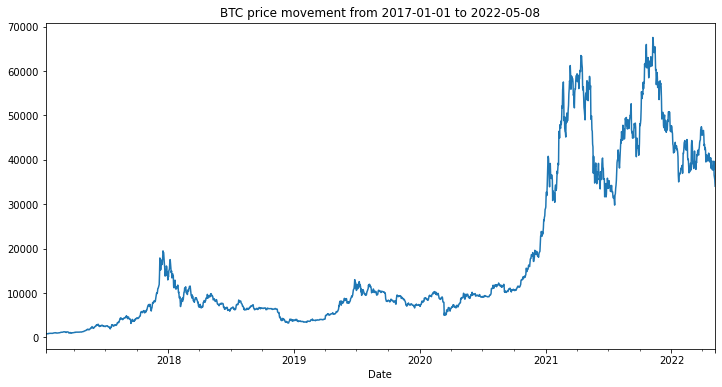

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys
sys.path.append('../src')
from data_load.csvs import get_asset_price_history
from strategies import WeeklyDCA, MonthlyDCA, WeeklyFNGDCA, WeeklyCategoricalFNGDCA, WeeklyRollingZScoreDCA, WeeklyCategoricalZScoreDCA, WeeklyZFNGDCA, WeeklyRSIDCA

# Set experiment parameters

START = "2017-01-01"
END = "2022-05-08"
ASSET = "BTC"
WEEKLY_INVESTMENT = 100

# Collect BTC data

df = get_asset_price_history(ASSET, START, END)

display(pd.concat([df.head(5), df.tail(5)]))

df.Close.plot(figsize=(12, 6))
plt.title(f"{ASSET} price movement from {START} to {END}")


## Which DCA strategy performed better from January 2017 to May 2022?

In [69]:
experiments = []
strategies = {
    "weekly": {
        "params":["Monday", "Tuesday","Wednesday", "Thurstday", "Friday", "Saturday", "Sunday" ], 
        "strategies": [ WeeklyDCA, WeeklyFNGDCA, WeeklyCategoricalFNGDCA, WeeklyRollingZScoreDCA, WeeklyCategoricalZScoreDCA, WeeklyZFNGDCA, WeeklyRSIDCA]
    },
    "monthly": {
        "params": list(range(1, 32)),
        "strategies": [ MonthlyDCA ]
    }
}

for k, v in strategies.items():
    for param in v["params"]:
        for strategy_class in v["strategies"]:
            investment = WEEKLY_INVESTMENT * 4 if k == "monthly" else WEEKLY_INVESTMENT
            strategy = strategy_class(investment, param)
            bt = strategy.backtest(strategy.apply(strategy.preprocess(df)))
            experiments.append(bt)
            
experiments = pd.DataFrame(experiments)

/Users/denis/Documents/Personal/Projects/research/dca-ideas/notebooks/../src/strategies/base.py:47: RuntimeWarning: invalid value encountered in double_scalars
  strategy_fiat_gain_percent = strategy_fiat_gain_absolute / total_fiat_invested * 100.0
/Users/denis/Documents/Personal/Projects/research/dca-ideas/notebooks/../src/strategies/base.py:48: RuntimeWarning: invalid value encountered in true_divide
  strategy_average_asset_price = total_fiat_invested / strategy_asset_position
/Users/denis/Documents/Personal/Projects/research/dca-ideas/notebooks/../src/strategies/base.py:47: RuntimeWarning: invalid value encountered in double_scalars
  strategy_fiat_gain_percent = strategy_fiat_gain_absolute / total_fiat_invested * 100.0
/Users/denis/Documents/Personal/Projects/research/dca-ideas/notebooks/../src/strategies/base.py:48: RuntimeWarning: invalid value encountered in double_scalars
  strategy_average_asset_price = total_fiat_invested / strategy_asset_position
/Users/denis/Documents/Pers

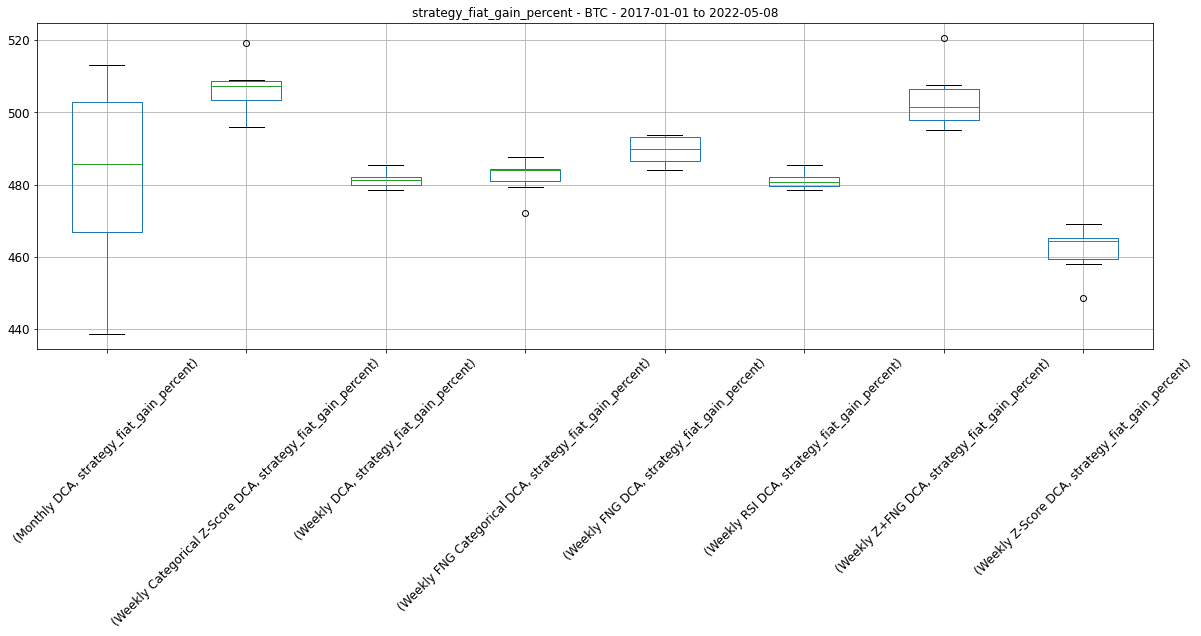

In [70]:

for c in ["strategy_fiat_gain_percent"]:
    experiments[["strategy", c]].groupby("strategy").boxplot(subplots=False, rot=45, fontsize=12, figsize=(20, 6))
    plt.title(f"{c} - {ASSET} - {START} to {END}")
    plt.show()

## What are the best days to DCA? 
Of course, if you have any DCA day you are already on the right track. However, since picking one day or one other does not require any additional effort, it would be interesting to know wheter there is actually a day performing better than the others.

In [71]:
best_setups = []
for i, (strategy, strategy_experiments) in enumerate(experiments.groupby("strategy")):
    best_row = strategy_experiments[strategy_experiments.strategy_fiat_gain_percent == strategy_experiments.strategy_fiat_gain_percent.max()].iloc[0]
    worst_row = strategy_experiments[strategy_experiments.strategy_fiat_gain_percent == strategy_experiments.strategy_fiat_gain_percent.min()].iloc[0]
    
    best_setups.append({
        "strategy": strategy,
        "best_day": best_row.params.get("day_of_week", best_row.params.get("day_of_month")),
        "difference_from_mean": best_row.strategy_fiat_gain_percent / strategy_experiments.strategy_fiat_gain_percent.mean() - 1,
        "difference_from_worst": best_row.strategy_fiat_gain_percent / worst_row.strategy_fiat_gain_percent - 1,
    })
    
pd.DataFrame(best_setups)
    

,strategy,best_day,difference_from_mean,difference_from_worst
0,Monthly DCA,16,0.063582,0.169831
1,Weekly Categorical Z-Score DCA,Tuesday,0.024666,0.047366
2,Weekly DCA,Monday,0.008485,0.014643
3,Weekly FNG Categorical DCA,Tuesday,0.011445,0.032471
4,Weekly FNG DCA,Monday,0.008584,0.020111
5,Weekly RSI DCA,Monday,0.008717,0.014643
6,Weekly Z+FNG DCA,Tuesday,0.033149,0.051581
7,Weekly Z-Score DCA,Saturday,0.016227,0.045846


## Which DCA strategy is consistently better?

### Expectations

Let's take a single year as time frame for our example. Basing our expectations of the future only by measuring the performance over the last year would mean that we expect the next year to perform exactly as the one that just passed. This could result in overly optimistic or overly pessimistic expectations of our DCA strategy in the future. For example, considering the time window from Jan 2018 and Jan 2019 (-70% overall price performance) is very different from considering the time window from Jan 2020 to Jan 2021 (+400% overall price performance).

### Testing both Bearish and Bullish scenarios

For this reason, What I consider to be the more robust best way to measure the performance of a DCA strategy is to measure it over all the possible years we have experienced. To do this, all strategies will be tested on all periods of 365 days resulting from a sliding window over the whole data history. In this way strategies will be compared on both bearish and bullish scenarios.

In [72]:
strategies = {
    "weekly": {
        "params":["Tuesday"], 
        "strategies": [ WeeklyDCA, WeeklyFNGDCA, WeeklyCategoricalFNGDCA, WeeklyRollingZScoreDCA, WeeklyCategoricalZScoreDCA, WeeklyZFNGDCA, WeeklyRSIDCA]
    },
    "monthly": {
        "params": [16],
        "strategies": [ MonthlyDCA ]
    }
}

df = WeeklyFNGDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df)
df = WeeklyCategoricalFNGDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df)
df = WeeklyRollingZScoreDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df)
df = WeeklyCategoricalZScoreDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df)
df = WeeklyRSIDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df)
df = MonthlyDCA(WEEKLY_INVESTMENT*4, 15).preprocess(df)

In [100]:
def window_backtest(df_history, wl:int=365*3) -> pd.DataFrame:

    WINDOW_LENGTH = wl
    experiments = []
    all_dates = pd.date_range(df_history.index[0], df_history.index[-1], freq="D")


    for i in tqdm(range(len(all_dates) - WINDOW_LENGTH - 1)):
        
        start = all_dates[i]
        end = all_dates[i + WINDOW_LENGTH]
        df_window = df_history[start:end]
        
        first_price = df_window.iloc[0].Close
        last_price = df_window.iloc[-1].Close
        
        hodl_performance = (last_price - first_price) / first_price
        
        for k, v in strategies.items():
            for param in v["params"]:
                for strategy_class in v["strategies"]:
                    investment = WEEKLY_INVESTMENT * 4 if k == "monthly" else WEEKLY_INVESTMENT
                    strategy = strategy_class(investment, param)
                    bt = strategy.backtest(strategy.apply(df_window[start:end]))
                    bt["start_date"] = start
                    bt["end_date"] = end
                    bt["hodl_performance"] = hodl_performance
                    bt["hodl_fiat_value"] = bt["total_fiat_invested"] + bt["total_fiat_invested"] * hodl_performance
                    bt["relative_performance"] = (bt["strategy_fiat_value"] - bt["hodl_fiat_value"]) / bt["hodl_fiat_value"]
                    experiments.append(bt)
                
    experiments = pd.DataFrame(experiments)
    return experiments     

In [74]:
semesters = window_backtest(df, 365 // 2)
year = window_backtest(df, 365)
two_years = window_backtest(df, 365 * 2)
three_years = window_backtest(df, 365 * 3)

  0%|          | 0/1771 [00:00<?, ?it/s]

  0%|          | 0/1588 [00:00<?, ?it/s]

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

In [75]:
from plots import plot_window_backtest

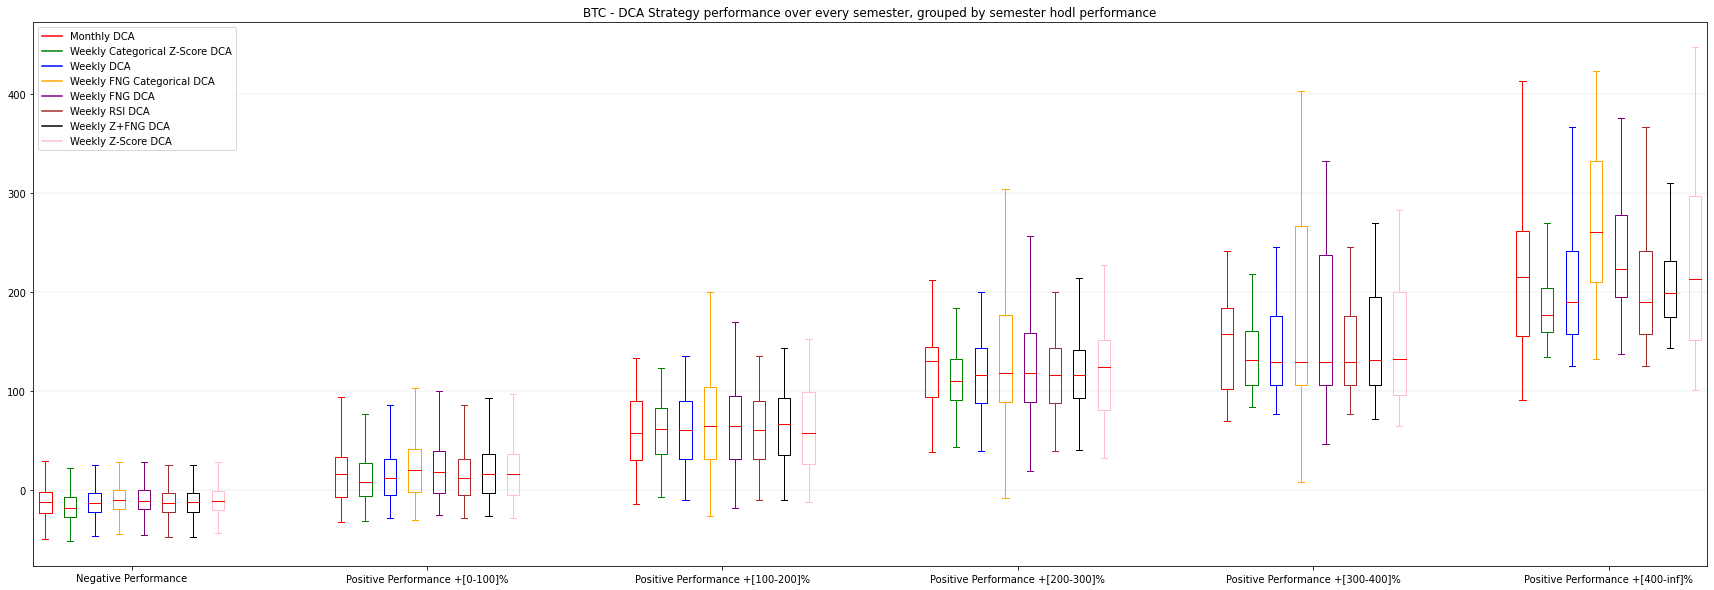

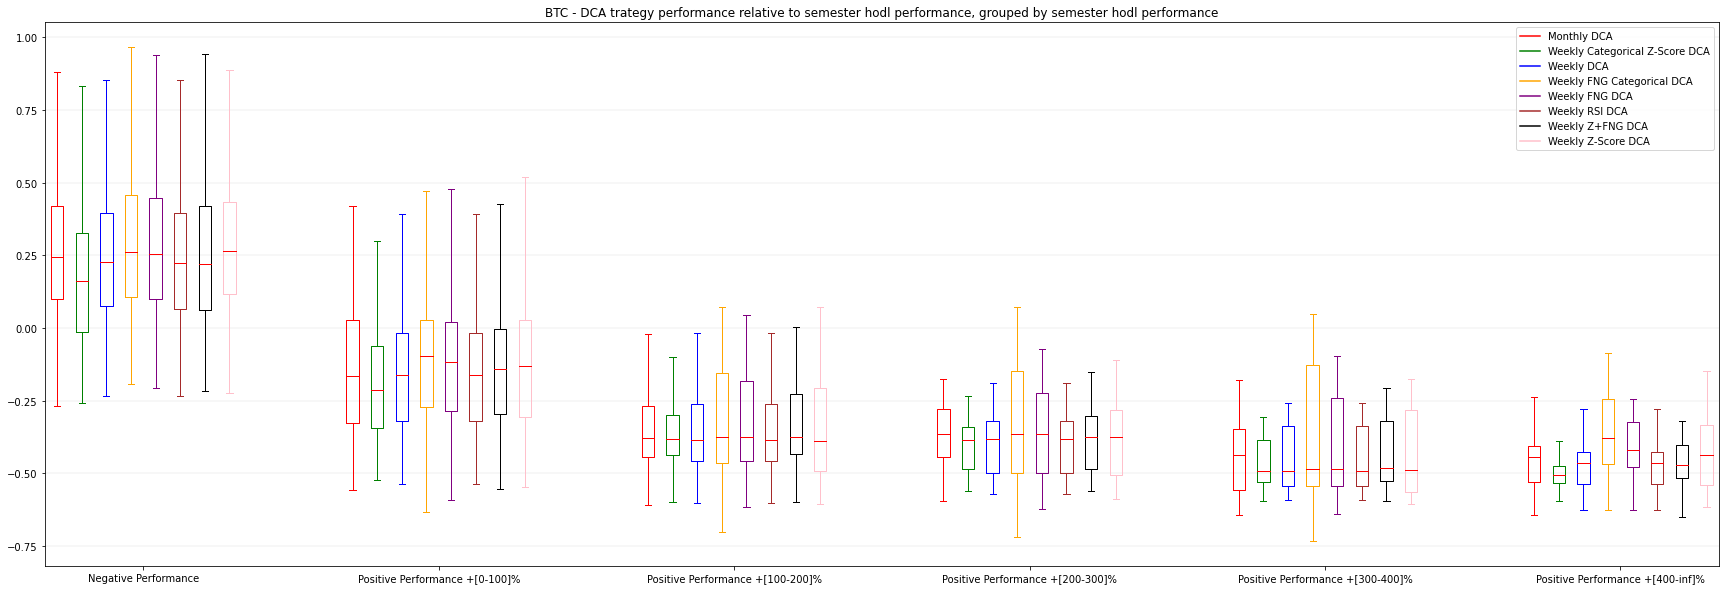

In [76]:
plot_window_backtest(semesters, title="BTC - DCA Strategy performance over every semester, grouped by semester hodl performance")
plot_window_backtest(semesters, relative_performance=True, title="BTC - DCA trategy performance relative to semester hodl performance, grouped by semester hodl performance")


### Example:

 *If I wanted to follow a DCA strategy for **one year** and I expect to enter a **bear** market, which one would I choose?*


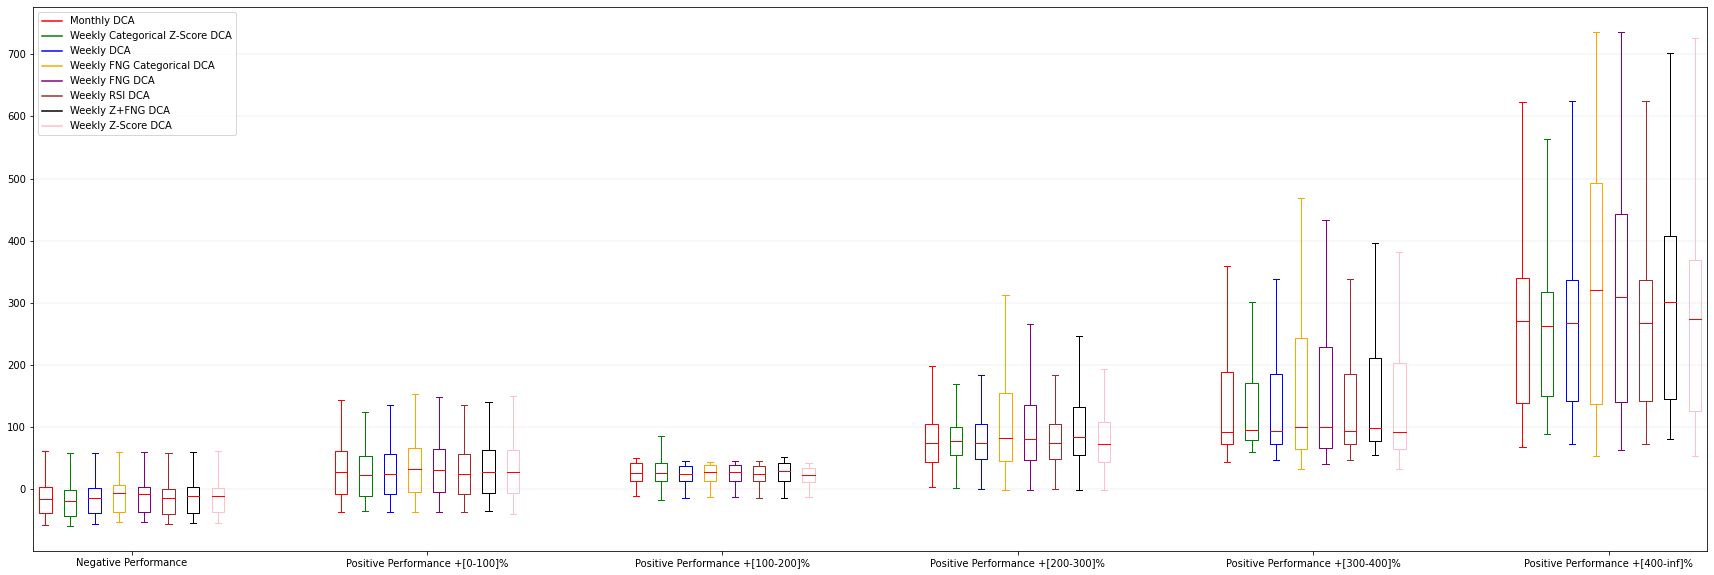

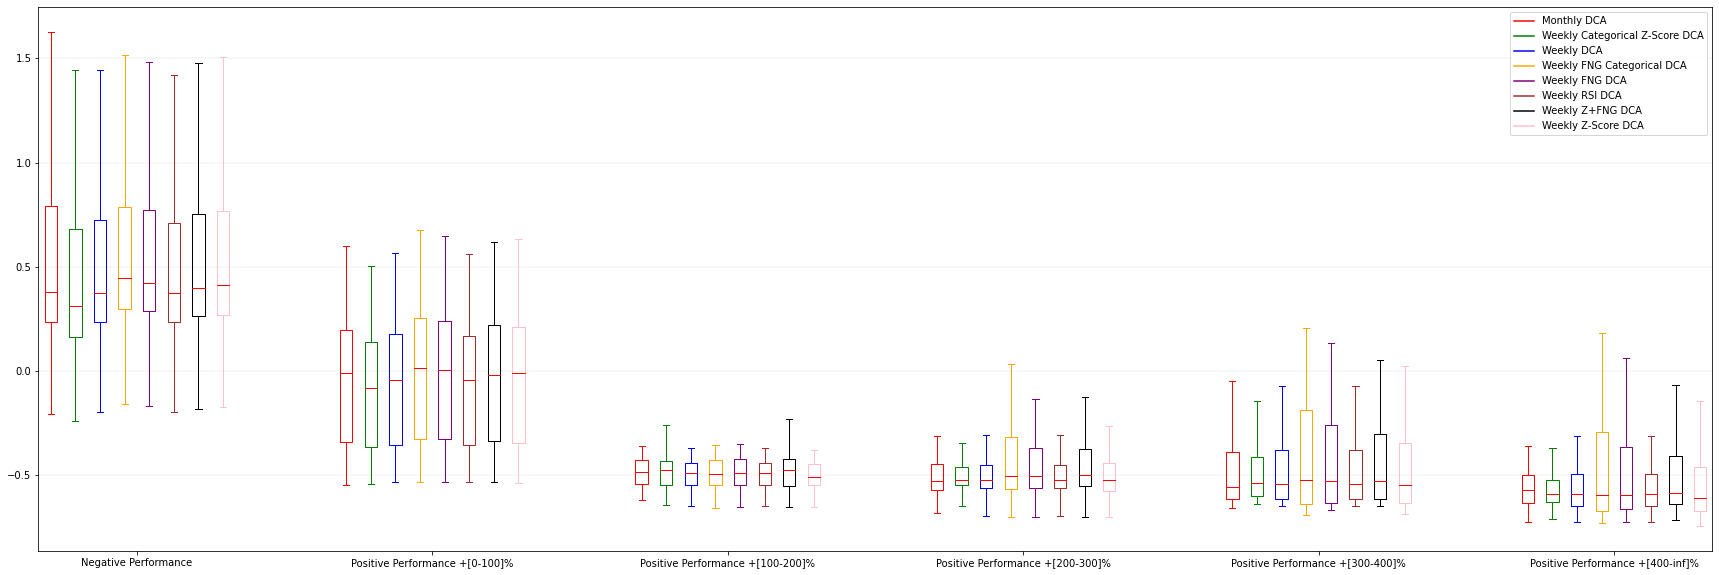

In [77]:
plot_window_backtest(year)
plot_window_backtest(year, relative_performance=True)

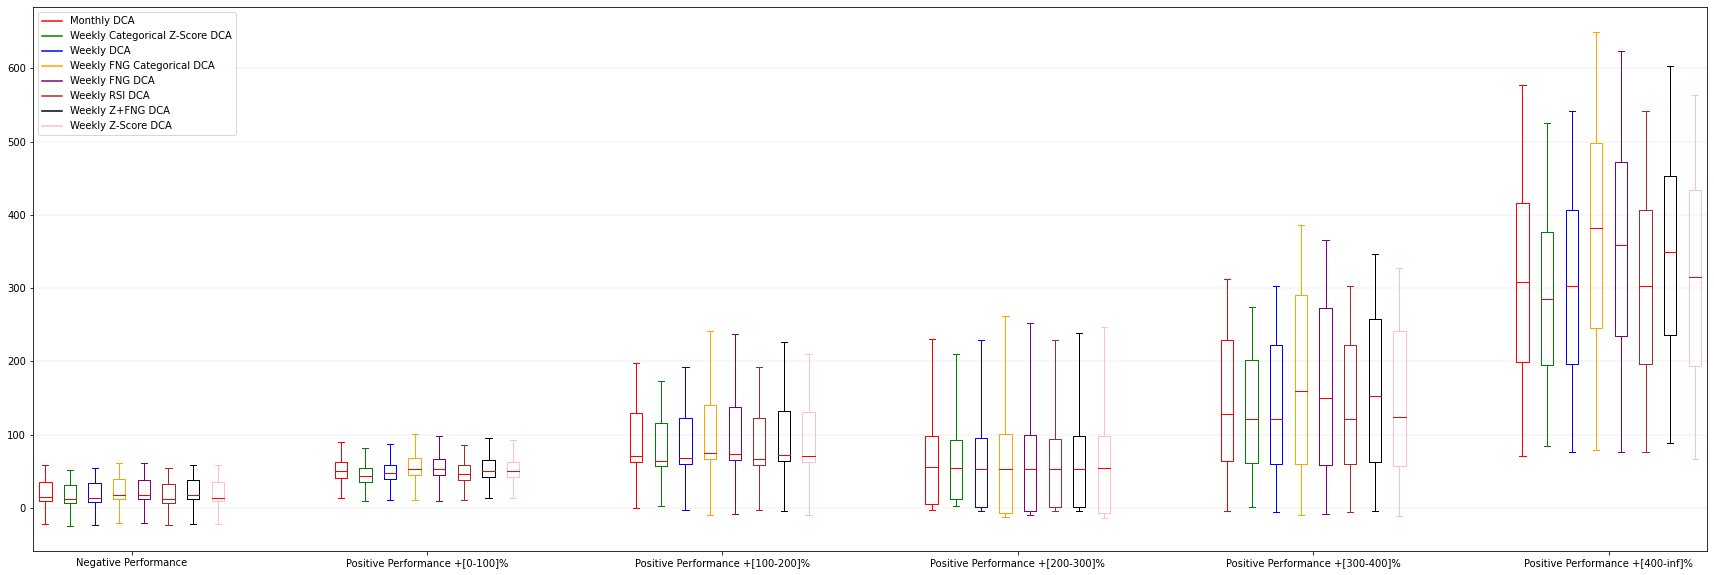

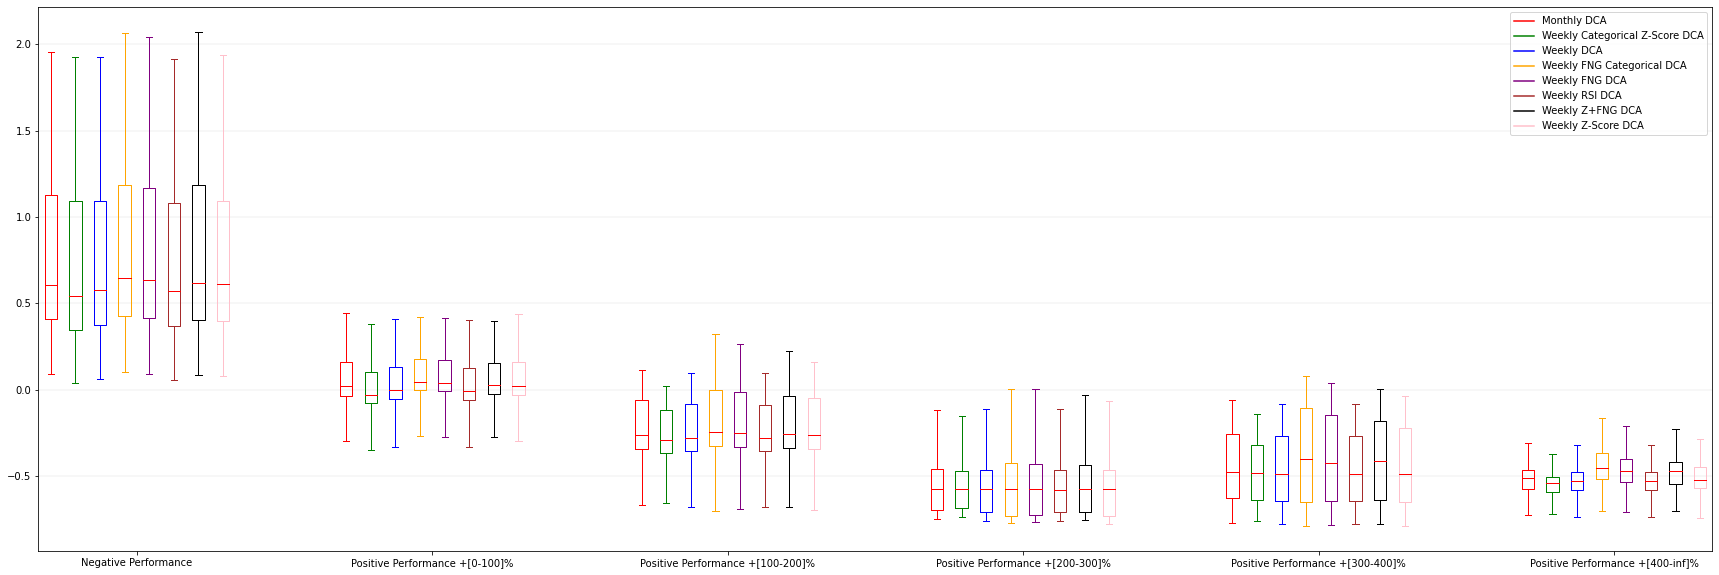

In [78]:
plot_window_backtest(two_years)
plot_window_backtest(two_years, relative_performance=True)

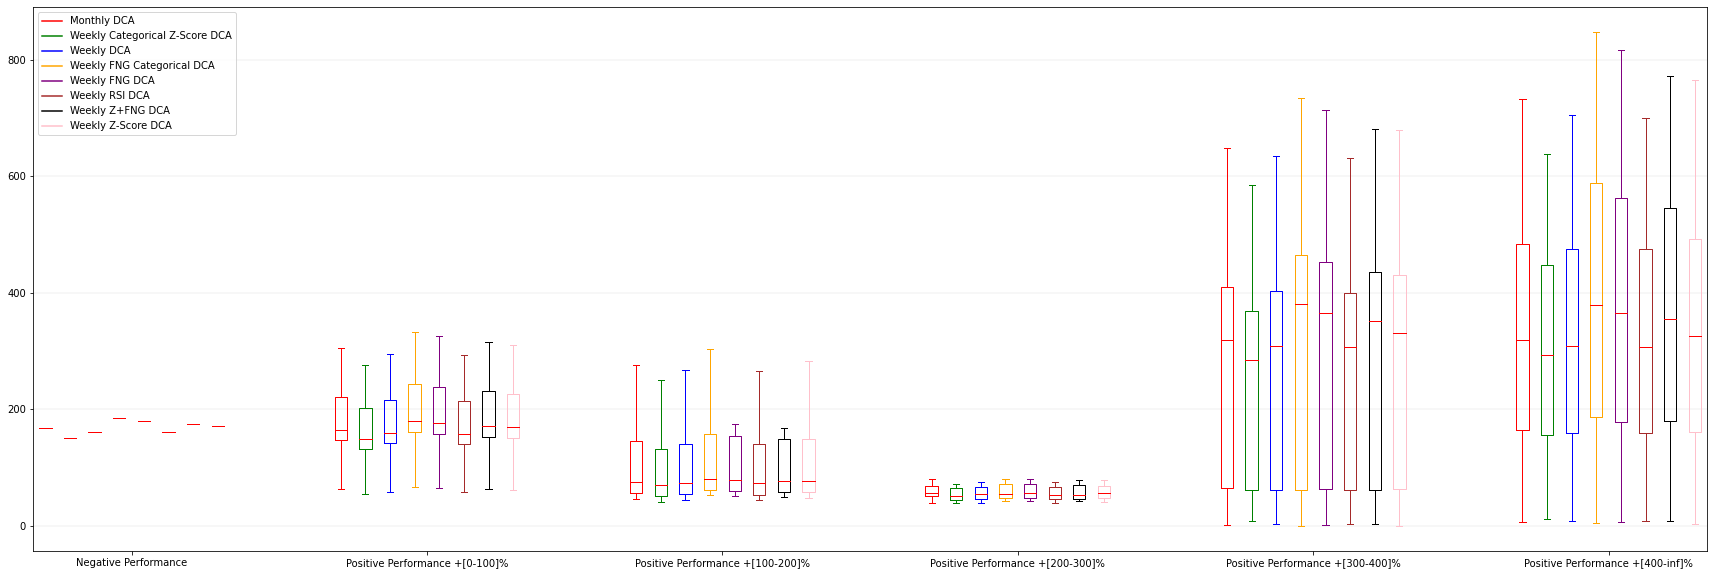

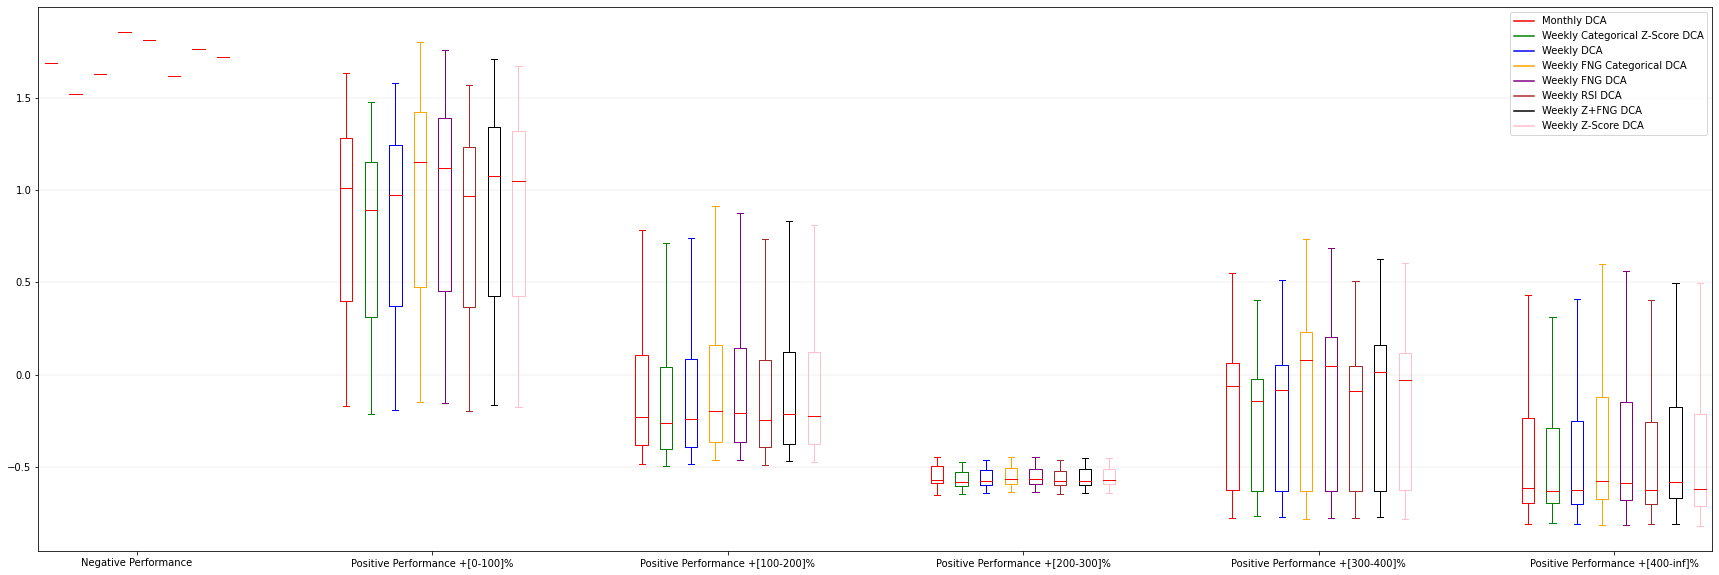

In [79]:
plot_window_backtest(three_years)
plot_window_backtest(three_years, relative_performance=True)

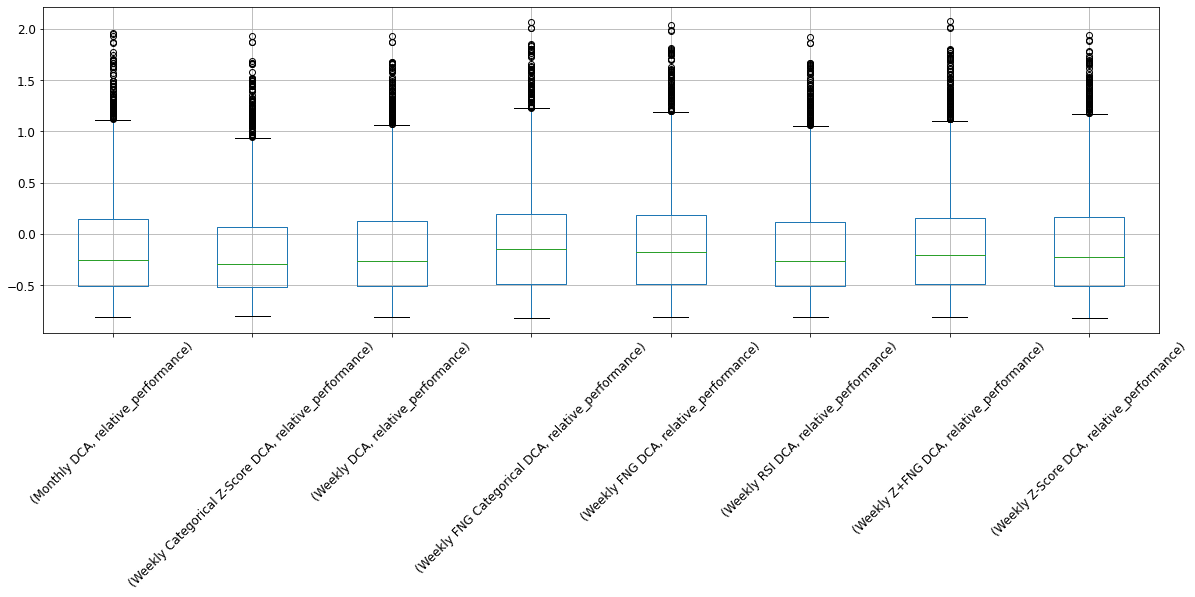

In [80]:
pd.concat([ semesters, year, two_years, three_years]).reset_index(drop=True)[["strategy", "relative_performance"]].groupby("strategy").boxplot(subplots=False, rot=45, fontsize=12, figsize=(20, 6))
plt.show()

In [81]:
strategy_means = pd.concat([ semesters, year, two_years, three_years]).reset_index(drop=True)[["strategy", "relative_performance"]].groupby("strategy").mean()

s_m_mean = strategy_means.relative_performance.mean()
s_m_min = strategy_means.relative_performance.min()
s_m_classic_dca = strategy_means[strategy_means.index=="Weekly DCA"]["relative_performance"].values[0]

strategy_means = strategy_means.assign(difference_from_mean=strategy_means.relative_performance - s_m_mean)
strategy_means = strategy_means.assign(difference_from_worst=strategy_means.relative_performance - s_m_min)
strategy_means = strategy_means.assign(difference_from_classic_DCA=strategy_means.relative_performance - s_m_classic_dca)

strategy_means.style.highlight_max(color = 'lightgreen', axis = 0)


,relative_performance,difference_from_mean,difference_from_worst,difference_from_classic_DCA
strategy,,,,
Monthly DCA,-0.151585,-0.004394,0.041426,0.013433
Weekly Categorical Z-Score DCA,-0.193010,-0.045820,0.000000,-0.027993
Weekly DCA,-0.165017,-0.017827,0.027993,0.000000
Weekly FNG Categorical DCA,-0.104468,0.042722,0.088542,0.060549
Weekly FNG DCA,-0.119433,0.027757,0.073578,0.045585
Weekly RSI DCA,-0.166746,-0.019555,0.026265,-0.001728
Weekly Z+FNG DCA,-0.134535,0.012655,0.058475,0.030482
Weekly Z-Score DCA,-0.142728,0.004462,0.050283,0.022290


## Considerations
DCA in average underperforms lump sum investments by 15% (classic Monthly DCA and Weekly DCA). If we tweak the investments by recurring to world information we can reduce the gap to 10% (Weekly FNG Categorical DCA strategy). An improvement of 6% without further efforts is very welcome for DCA investors.

## ETH

In [85]:
ASSET = "ETH"
START = "2017-01-01"
END = "2022-05-08"
WEEKLY_INVESTMENT = 100

df_eth_usd = get_asset_price_history(ASSET, START, END)
df_eth_usd

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2022-05-04,2783.131104,2956.686768,2779.273682,2940.644775,2940.644775,18186749944
2022-05-05,2940.226563,2948.960693,2704.916260,2749.213135,2749.213135,22642925048
2022-05-06,2748.931641,2754.837646,2645.335205,2694.979736,2694.979736,21027599270


In [86]:

df_eth_usd = WeeklyFNGDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df_eth_usd)
df_eth_usd = WeeklyCategoricalFNGDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df_eth_usd)
df_eth_usd = WeeklyRollingZScoreDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df_eth_usd)
df_eth_usd = WeeklyCategoricalZScoreDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df_eth_usd)
df_eth_usd = WeeklyRSIDCA(WEEKLY_INVESTMENT, "Tuesday").preprocess(df_eth_usd)
df_eth_usd = MonthlyDCA(WEEKLY_INVESTMENT*4, 15).preprocess(df_eth_usd)


In [101]:

semesters = window_backtest(df_eth_usd, 365 // 2)
year = window_backtest(df_eth_usd, 365)
two_years = window_backtest(df_eth_usd, 365 * 2)
three_years = window_backtest(df_eth_usd, 365 * 3)


  0%|          | 0/1459 [00:00<?, ?it/s]

  0%|          | 0/1276 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

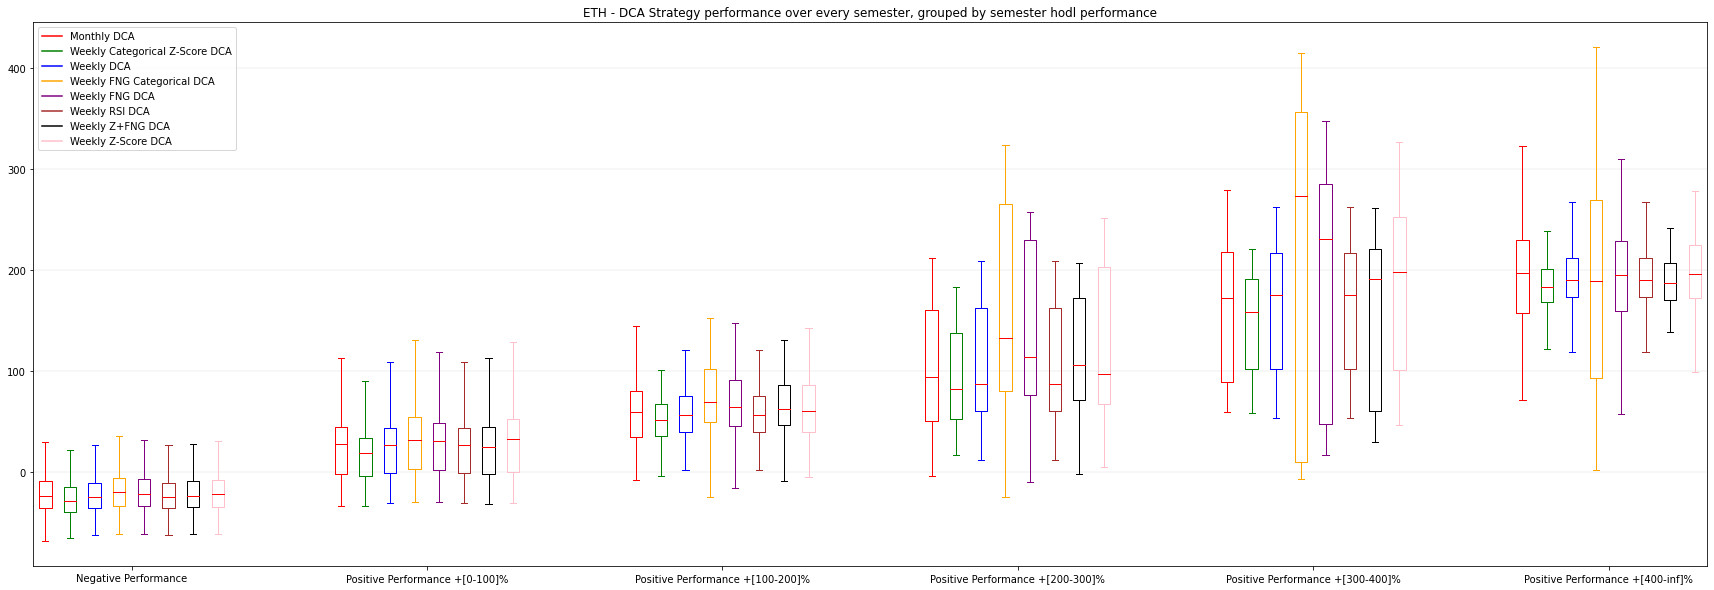

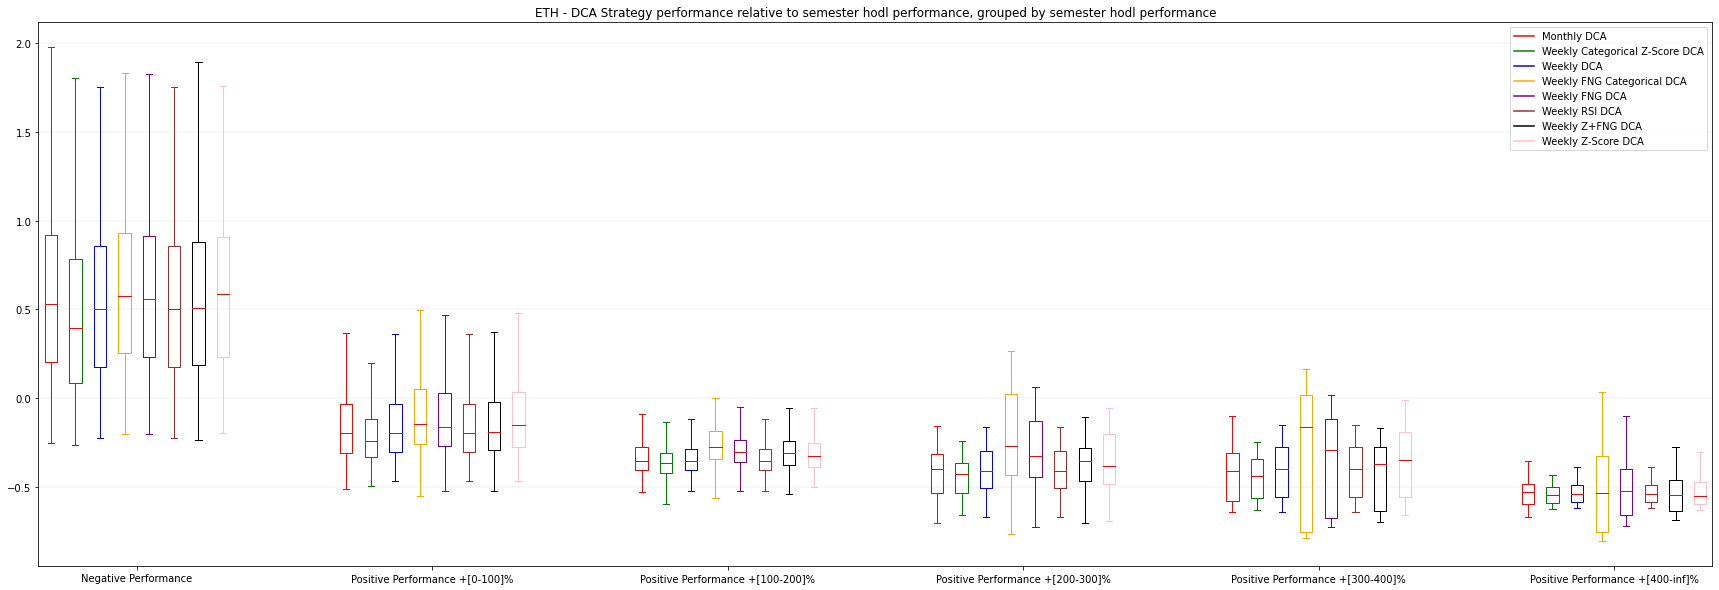

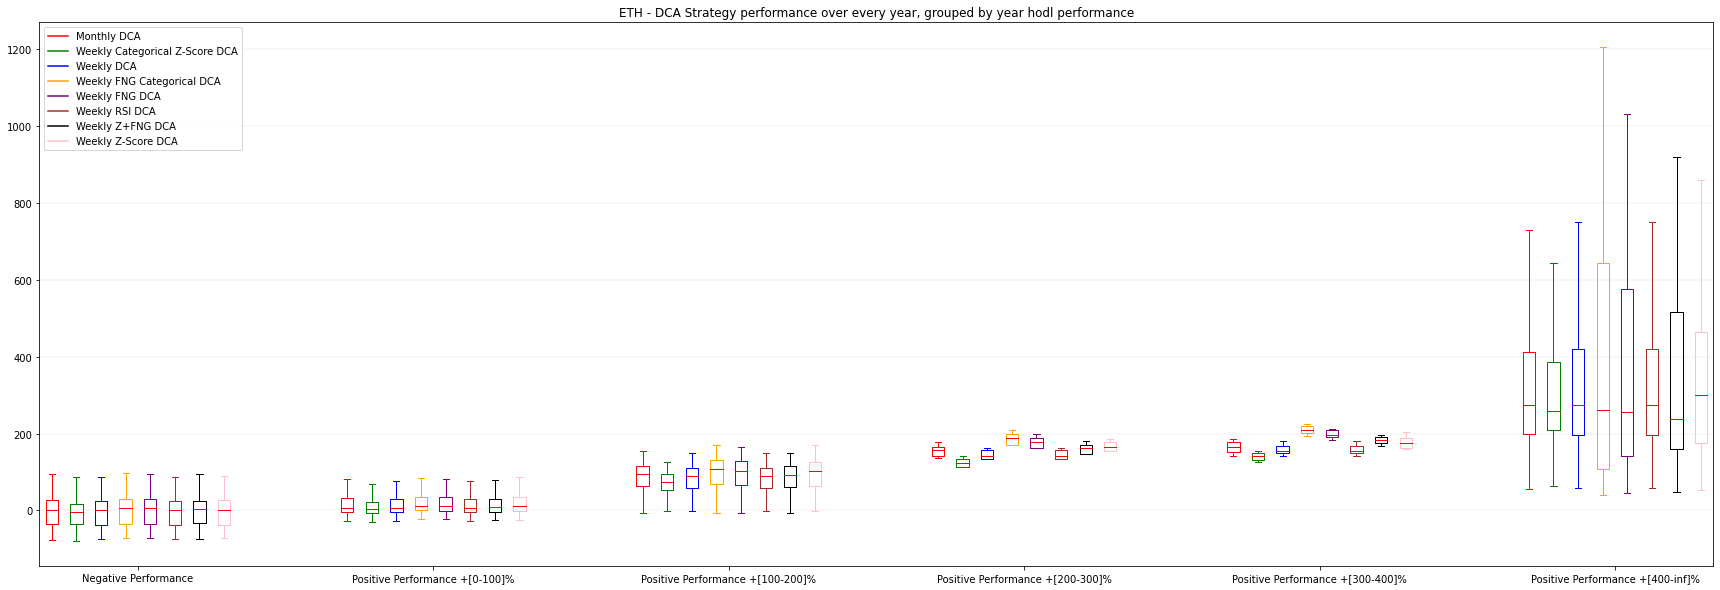

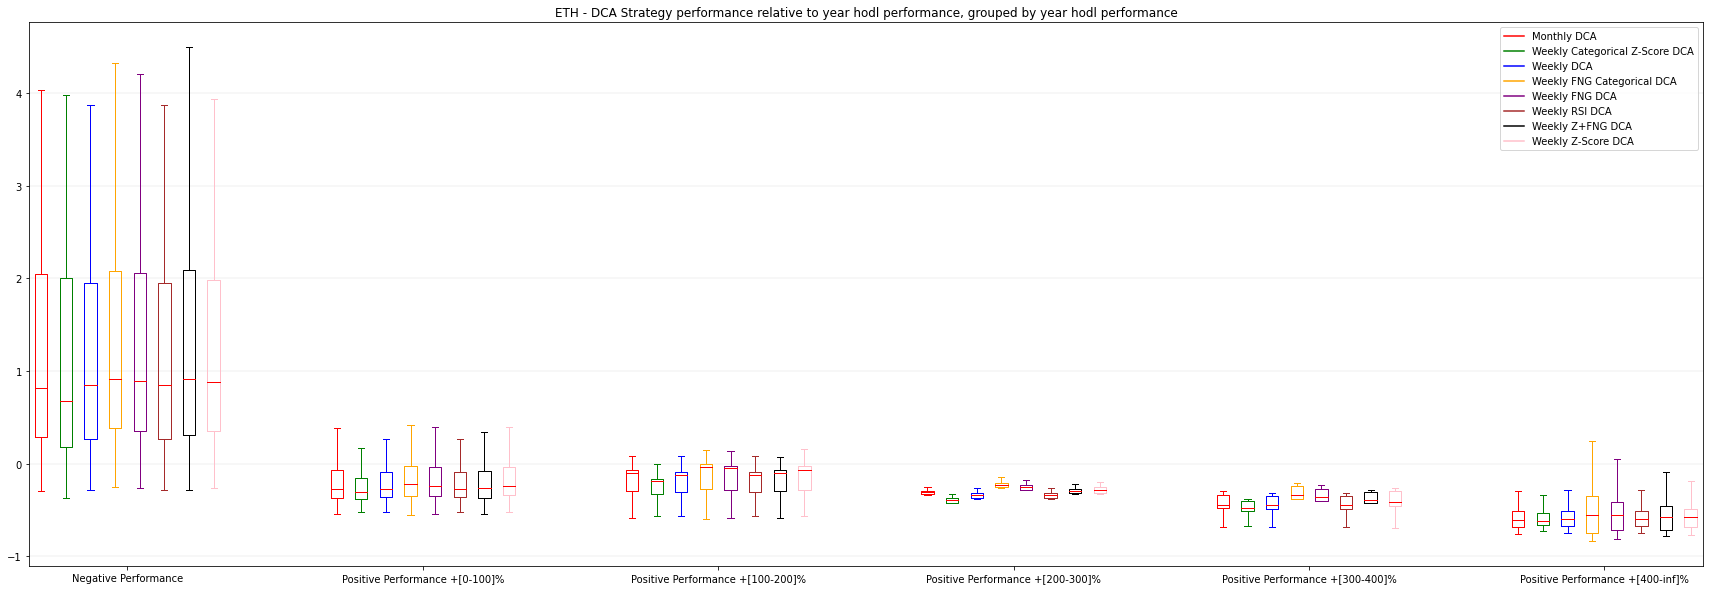

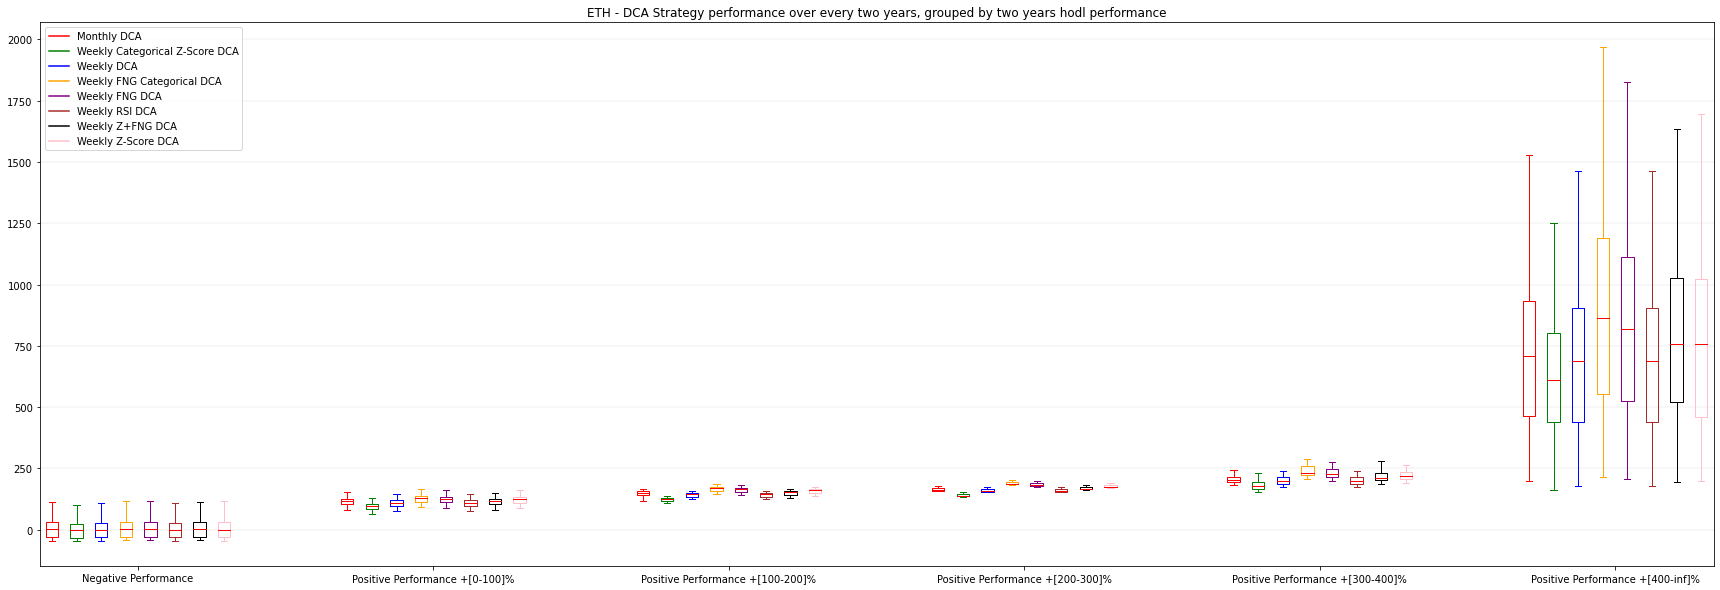

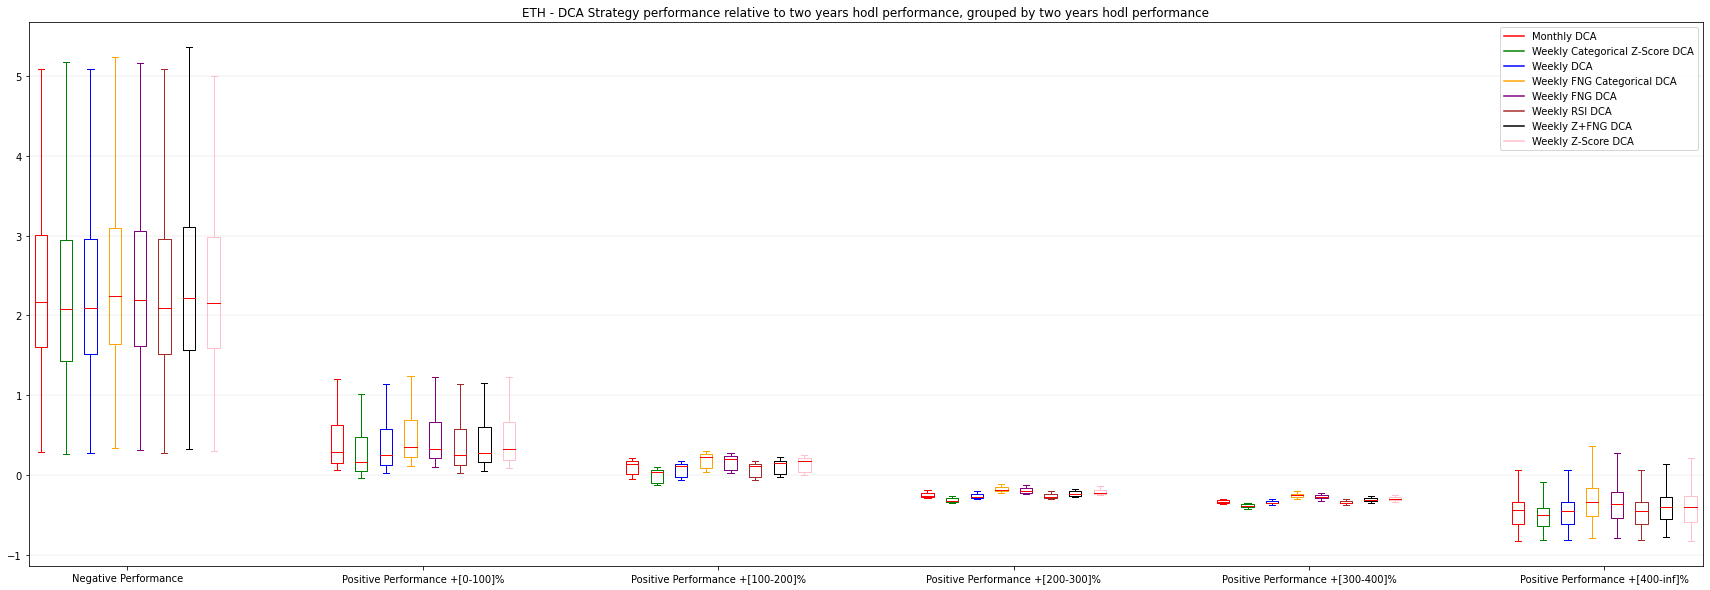

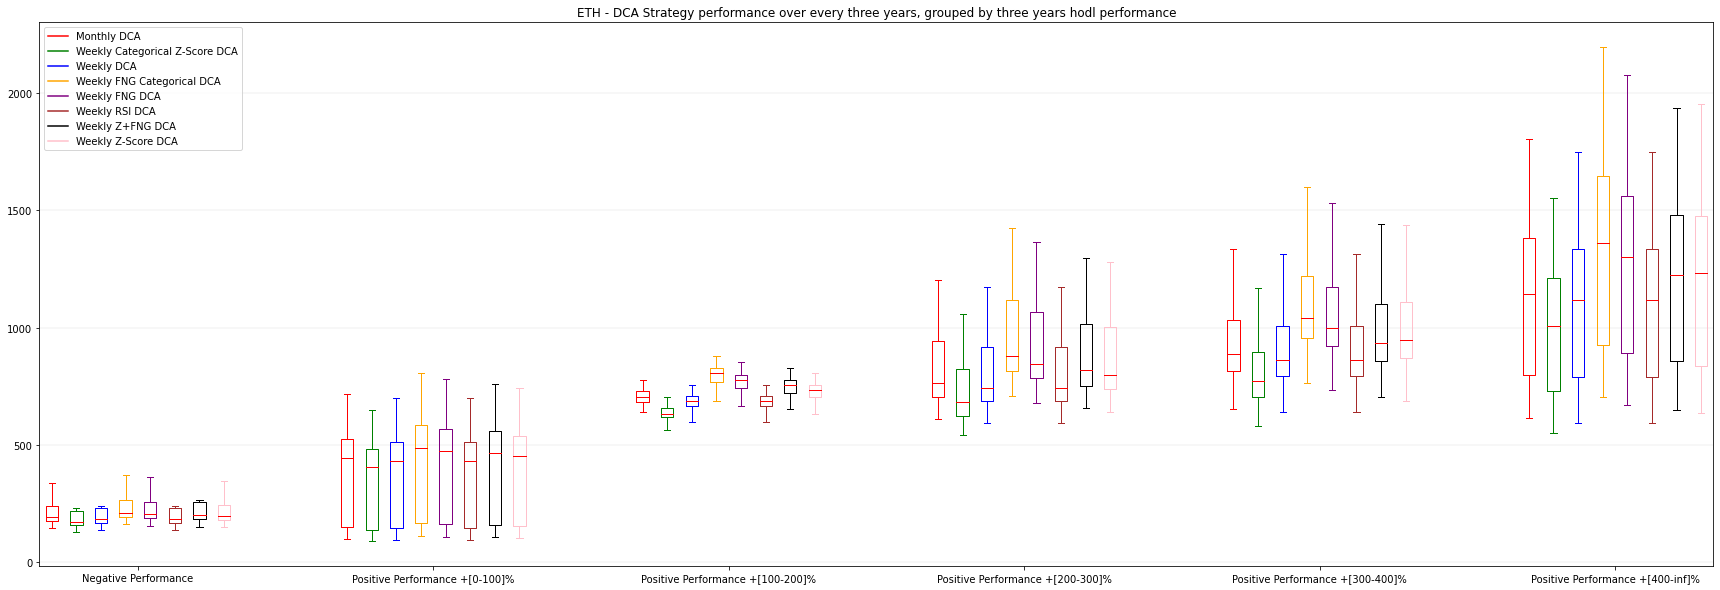

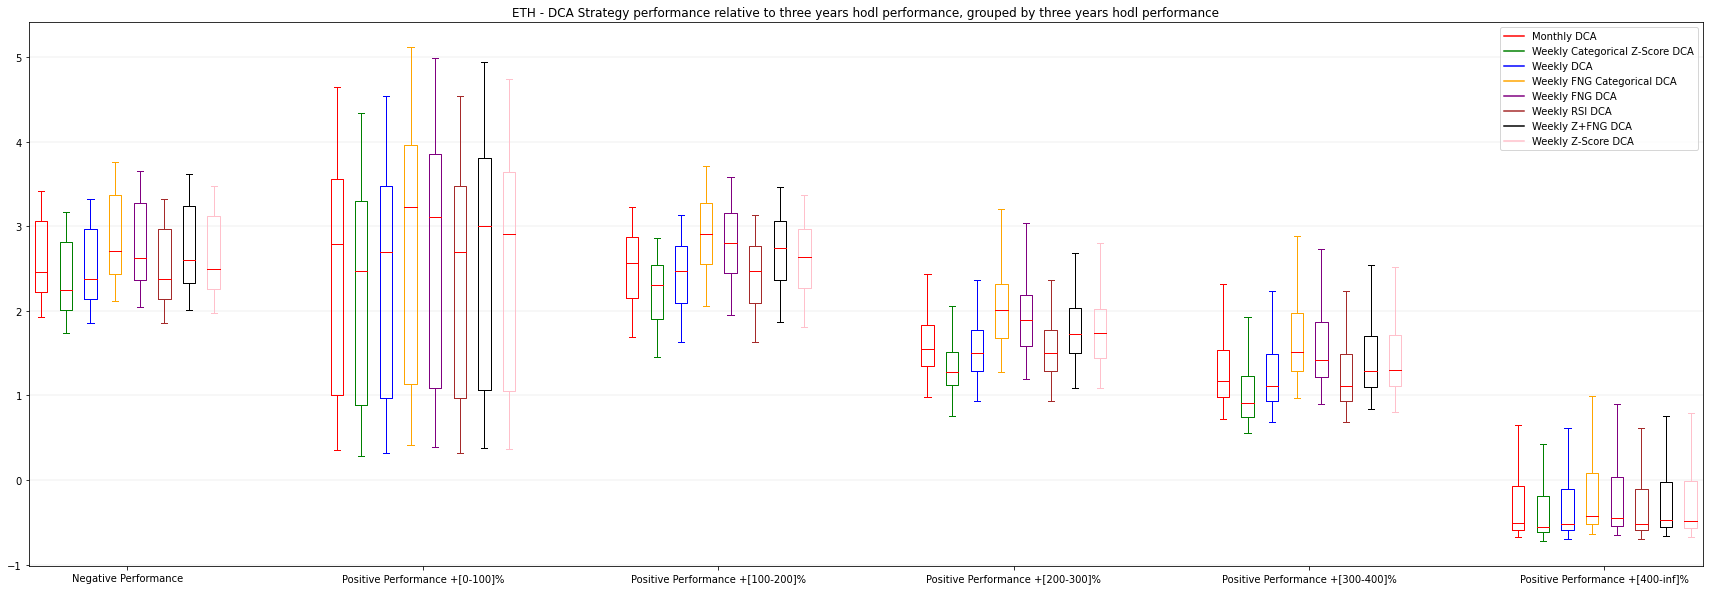

,relative_performance,difference_from_mean,difference_from_worst,difference_from_classic_DCA
strategy,,,,
Monthly DCA,0.294614,-0.008198,0.081359,0.025080
Weekly Categorical Z-Score DCA,0.213256,-0.089556,0.000000,-0.056279
Weekly DCA,0.269535,-0.033277,0.056279,0.000000
Weekly FNG Categorical DCA,0.379385,0.076573,0.166129,0.109851
Weekly FNG DCA,0.351085,0.048273,0.137829,0.081550
Weekly RSI DCA,0.269535,-0.033277,0.056279,0.000000
Weekly Z+FNG DCA,0.322996,0.020184,0.109740,0.053461
Weekly Z-Score DCA,0.322091,0.019279,0.108836,0.052557


In [102]:

plot_window_backtest(semesters, title="ETH - DCA Strategy performance over every semester, grouped by semester hodl performance")
plot_window_backtest(semesters, relative_performance=True, title="ETH - DCA Strategy performance relative to semester hodl performance, grouped by semester hodl performance")


plot_window_backtest(year, title="ETH - DCA Strategy performance over every year, grouped by year hodl performance")
plot_window_backtest(year, relative_performance=True, title="ETH - DCA Strategy performance relative to year hodl performance, grouped by year hodl performance")


plot_window_backtest(two_years, title="ETH - DCA Strategy performance over every two years, grouped by two years hodl performance")
plot_window_backtest(two_years, relative_performance=True, title="ETH - DCA Strategy performance relative to two years hodl performance, grouped by two years hodl performance")


plot_window_backtest(three_years, title="ETH - DCA Strategy performance over every three years, grouped by three years hodl performance")
plot_window_backtest(three_years, relative_performance=True, title="ETH - DCA Strategy performance relative to three years hodl performance, grouped by three years hodl performance")

strategy_means = pd.concat([ semesters, year, two_years, three_years]).reset_index(drop=True)[["strategy", "relative_performance"]].groupby("strategy").mean()

s_m_mean = strategy_means.relative_performance.mean()
s_m_min = strategy_means.relative_performance.min()
s_m_classic_dca = strategy_means[strategy_means.index=="Weekly DCA"]["relative_performance"].values[0]

strategy_means = strategy_means.assign(difference_from_mean=strategy_means.relative_performance - s_m_mean)
strategy_means = strategy_means.assign(difference_from_worst=strategy_means.relative_performance - s_m_min)
strategy_means = strategy_means.assign(difference_from_classic_DCA=strategy_means.relative_performance - s_m_classic_dca)

strategy_means.style.highlight_max(color = 'lightgreen', axis = 0)